### Imports and reading data

In [234]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#Import scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Import pipeline
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

In [235]:
data = pd.read_csv('train.csv')

In [236]:
data.coco.value_counts()

1.0     1815
2.0     1716
4.0     1467
3.0     1120
14.0     767
7.0      623
5.0      232
17.0     179
18.0     113
21.0     104
8.0       94
12.0      48
15.0      38
10.0      18
9.0       17
25.0      15
19.0      13
22.0      10
13.0       2
6.0        2
16.0       1
20.0       1
23.0       1
Name: coco, dtype: int64

### Data exploration

In [237]:
# Loop through the data indeces
def extend_snow(data):
    data['snow'] = data['snow'].fillna(0)
    snow = 0
    replaceCounter = 0
    for i in range(len(data)):
        # If snowfall is not 0, save the value
        if data['snow'][i] != 0:
            snow = data['snow'][i]
            # Replace the following 24 hours with the saved value
            replaceCounter = 23
        elif (replaceCounter > 0):
            data['snow'][i] = snow
            replaceCounter -= 1
    return data
    
def avg_temp_day_before(data):
    temp = 0
    temp_count = 0
    for i in range(len(data)):
        temp += data['temp'][i]
        temp_count += 1
        if ((i + 1) % 24 == 0):
            for j in range(24):
                data['avg_temp_day_before'][i-j] = temp / temp_count
            temp = 0
            temp_count = 0
    return data

### Data Preprocessing

In [238]:
def preprocess_data(data):

    # Time [time]
    # Splitting time into month, day, hour columns
    data['month'] = data['time'].apply(lambda x: int(x.split('-')[1]))
    data['day'] = data['time'].apply(
        lambda x: int(x.split('-')[2].split(' ')[0]))
    data['hour'] = data['time'].apply(
        lambda x: int(x.split(' ')[1].split(':')[0]))



    # Creating a new column for day of the week (0 = Monday, 6 = Sunday)
    data['date'] = data['time'].apply(lambda x: x.split(' ')[0])
    data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
    # Turning day of the week into a cyclic feature
    data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
    data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))
    # Creating weekend column
    data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

    data = data.drop(['day_of_week'], axis=1)


    # Transform day of the month into a cyclic feature
    data['day_sin'] = np.sin(2 * np.pi * data['day']/31)
    data['day_cos'] = np.cos(2 * np.pi * data['day']/31)
    data = data.drop(['day'], axis=1)

    # Dropping and date column
    data = data.drop(['date'], axis=1)
    

    # Turning hour into a cyclic feature
    data['hour_sin'] = data['hour'].apply(
        lambda x: np.sin(x * (2 * np.pi / 24)))
    data['hour_cos'] = data['hour'].apply(
        lambda x: np.cos(x * (2 * np.pi / 24)))
    data = data.drop(['hour'], axis=1)


    # Tranforming month column
    data['month_sin'] = data['month'].apply(
        lambda x: np.sin(x * (2 * np.pi / 12)))
    data['month_cos'] = data['month'].apply(
        lambda x: np.cos(x * (2 * np.pi / 12)))
    data = data.drop(['month'], axis=1)

    data = data.drop(['time'], axis=1)
    # Temp [temp]

    # Dew Point [dwpt]

    # Humidity [rhum]

    # Hourly Precipitation [prcp]
    #DROP PRCP
    data = data.drop(['prcp'], axis=1)

    # Snow depth [snow]

    data = extend_snow(data)

    # Wind direction [wdir]
    # Transforming wind direction into sin and cos

    data['wdir_sin'] = data['wdir'].apply(
        lambda x: np.sin(x * (2 * np.pi / 360)))
    data['wdir_cos'] = data['wdir'].apply(
        lambda x: np.cos(x * (2 * np.pi / 360)))
    # Dropping wind direction column
    data = data.drop(['wdir'], axis=1)

    # Wind speed [wspd]

    # Peak wind gust [wpgt]

    # Pressure [pres]
    data['pres'] = data['pres'].apply(lambda x: x-1000)

    # Condition code [coco]

    # electricity price [el_price]

    # Create feature for the avg temp day before
    data['avg_temp_day_before'] = 0
    data = avg_temp_day_before(data)

    data = data.fillna(0)

    return data

data = preprocess_data(data)
data.head()

C:\Users\tktaa\AppData\Local\Temp\ipykernel_33184\313115298.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['snow'][i] = snow
C:\Users\tktaa\AppData\Local\Temp\ipykernel_33184\313115298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_day_before'][i-j] = temp / temp_count


,temp,dwpt,rhum,snow,wspd,wpgt,pres,coco,el_price,consumption,...,weekend,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,avg_temp_day_before
0,11.2,10.3,94.0,0.0,7.2,16.7,12.6,2.0,0.09016,0.577,...,0,0.201299,0.97953,0.000000,1.000000,-1.0,-1.836970e-16,-0.642788,0.766044,12.6
1,10.7,9.6,93.0,0.0,7.2,13.0,12.6,2.0,0.09251,0.594,...,0,0.201299,0.97953,0.258819,0.965926,-1.0,-1.836970e-16,-0.642788,0.766044,12.6
2,9.9,9.0,94.0,0.0,7.2,13.0,12.2,2.0,0.08890,0.685,...,0,0.201299,0.97953,0.500000,0.866025,-1.0,-1.836970e-16,-0.642788,0.766044,12.6
3,10.0,8.4,90.0,0.0,7.2,13.0,11.9,1.0,0.08735,1.016,...,0,0.201299,0.97953,0.707107,0.707107,-1.0,-1.836970e-16,-0.500000,0.866025,12.6
4,9.0,8.1,94.0,0.0,3.6,13.0,11.4,2.0,0.08688,0.677,...,0,0.201299,0.97953,0.866025,0.500000,-1.0,-1.836970e-16,-0.866025,0.500000,12.6


### Split the data into training validation testing sets

In [239]:
X = data.drop(['consumption'], axis=1)
y = data['consumption']
print(X.shape, y.shape)

(8592, 21) (8592,)


In [240]:
while(False):
    # Cross-validation for parameter tuning, using the mean absolute error as the score
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    #Import models
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import HistGradientBoostingRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.ensemble import RandomForestRegressor

    kf = KFold(n_splits=10,shuffle=True ,random_state=1)
    rf = RandomForestRegressor(random_state=1)
    gbr = GradientBoostingRegressor(random_state=1)
    hgb = HistGradientBoostingRegressor(random_state=1)

    models = [rf, gbr, hgb]


    param_grid = {
        'loss': ['absolute_error'],
        'learning_rate': [0.23],
        'max_iter':[400],
        'max_leaf_nodes': [25,27,31,33,35],
    }


    grid = GridSearchCV(hgb, param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
    grid.fit(X,y)


In [241]:
import sklearn as skl
# Get the mean absolute error on the validation data

#print(grid.best_score_)
#print(grid.best_params_)
#print(grid.best_estimator_)

In [242]:
# rf 0.4662252188618
# rf (n estimators = 200) 0.4648049192422
# rf (n estimators = 350) 0.4640107180264
# rf (n estimators = 500, criterion = poisson) 0.4532568934810
# rf (n estimators = 500, criterion = poisson) avg_temp_day_before 0.44570050031861

# gbr 0.5970524860604666
# gbr (loss = huber, learning_rate = 0.21) 0.46681382521333
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300) 0.4579331869633
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4) 0.4576119234322
# gbr (
# loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4, alpha = 0.85
# ) 0.0.45735913420514607

# hgb 0.5910592077326
# hgb ('learning_rate': 0.2, 'loss': 'absolute_error') 0.4469123007557
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error') 0.4458115277666
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400) 0.44320934256139
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400, 'max_leaf_nodes': 27) 0.44121118797168


### Make a regression model using the training data

In [243]:

gbr = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb = HistGradientBoostingRegressor(
    learning_rate=0.23, loss='absolute_error', max_iter=400, max_leaf_nodes=27, random_state=1
    )
model = hgb.fit(X, y)

# Plotting feature importance
#feature_importance = model.feature_importances_
#feature_importance = 100.0 * \
#    (feature_importance / feature_importance.max())
#sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
#plt.figure(figsize=(12, 6))
#plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, X.columns[sorted_idx], color='white')
#plt.xlabel('Relative Importance')
#plt.title('Variable Importance')


### Make predictions using the testing data

In [244]:
make_prediction = True

In [245]:
if make_prediction:
    # Read in the test data
    test_data = pd.read_csv('test.csv')

    # Apply preprocessing to the test data
    test_data = preprocess_data(test_data)

    # Make predictions
    prediction = model.predict(test_data)

    # Create a dataframe with the predictions
    test_data = pd.read_csv('test.csv')
    test_data['consumption'] = prediction

    # Save the predictions to a csv file
    submission = test_data[['time', 'consumption']]
    submission.to_csv('submission.csv', index=False)

    # Write X to csv file
    X.to_csv('X.csv', index=False)

C:\Users\tktaa\AppData\Local\Temp\ipykernel_33184\313115298.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_day_before'][i-j] = temp / temp_count


In [246]:
submission.head()

,time,consumption
0,2022-08-25 00:00:00+03:00,0.364419
1,2022-08-25 01:00:00+03:00,0.190066
2,2022-08-25 02:00:00+03:00,0.227806
3,2022-08-25 03:00:00+03:00,0.405317
4,2022-08-25 04:00:00+03:00,0.753633


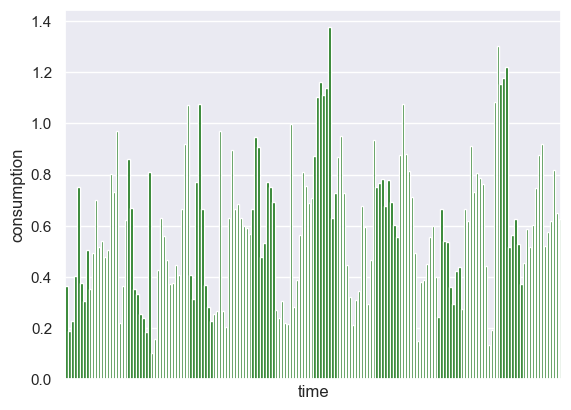

In [247]:
# Graphing the predictions

sns.set()
sns.barplot(x=test_data['time'], y=test_data['consumption'], color='green')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.show()



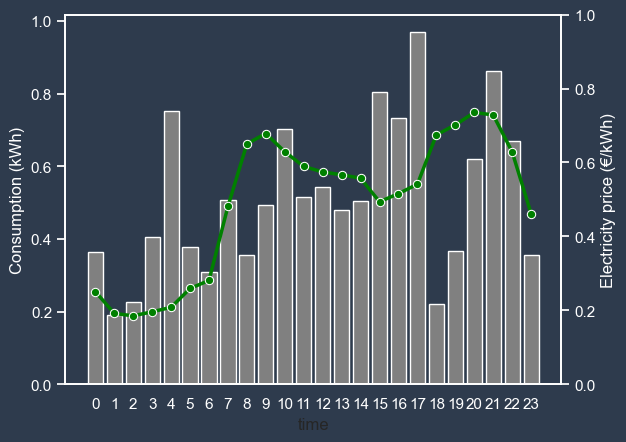

In [248]:
# Graphing 1 day of predictions
sns.set(rc={'axes.facecolor': '#2e3b4d', 'figure.facecolor': '#2e3b4d'})

# Make a df with predictions for 1 day and electricity price
# Take the first 24 hours
day = test_data[:24]
day = day.reset_index(drop=True)
day['el_price'] = test_data.el_price[:24]
day['time'] = day['time'].apply(lambda x: int(x.split(' ')[1].split(':')[0]))

# Plot the predictions
sns.barplot(x=day['time'], y=day['consumption'], color='gray')
sns.lineplot(x=day['time'], y=day['el_price'], color='green', marker='o', linewidth=2.5)
# First y-axis
plt.ylabel('Consumption (kWh)', color='white')
plt.tick_params(colors='white')
plt.grid(False)
# Second y-axis
ax2 = plt.twinx()
ax2.set_ylabel('Electricity price (€/kWh)', color='white')

# Set ax2 text color
ax2.tick_params(axis='y', colors='white')

ax2.grid(False)

plt.show()
# Show only hours
